# Policy Gradient on Racetrack Environment (Optimized)

This notebook implements a Policy Gradient method for a custom racetrack environment using PyTorch. It includes:
- Dynamic input size handling
- Entropy-based regularization
- Advantage normalization
- Gradient clipping
- **Performance optimization** by disabling rendering

We use the REINFORCE algorithm, which is a Monte Carlo policy gradient method for optimizing the policy network.

### 1. Imports and Device Configuration

We import the required libraries and set the device to CUDA if available.

In [62]:
import gymnasium as gym
import highway_env
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions import Normal
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 2. Training Mode and Render Settings

We define a simple flag to control whether the environment should render for visualization or run headlessly for training.

In [63]:
training = True
render_mode = None if training else "human"

: 

### 3. Environment Configuration

The configuration dictionary defines both the observation and action spaces, along with various simulation and reward parameters. Key features include:
- OccupancyGrid observation type with vehicle presence and road occupancy
- Continuous action space with lateral-only control (no acceleration)
- Reward structure penalizing collisions, drifting from the lane center, and overactive control
- Rendering is disabled when training to improve performance

In [49]:
config = {
    "observation": {
        "type": "OccupancyGrid",
        "features": ['presence', 'on_road', 'x'],
        "grid_size": [[-18, 18], [-18, 18]],
        "grid_step": [3, 3],
        "as_image": False,
        "align_to_vehicle_axes": True,
        "absolute": True,
    },
    "action": {
        "type": "ContinuousAction",
        "longitudinal": False,
        "lateral": True
    },
    "simulation_frequency": 15,
    "policy_frequency": 5,
    "duration": 100,
    "collision_reward": -1,
    "lane_centering_cost": 6,
    "lane_centering_reward": 2,
    "action_reward": -0.7,
    "controlled_vehicles": 1,
    "other_vehicles": 0,
    "screen_width": 600,
    "screen_height": 600,
    "centering_position": [0.5, 0.5],
    "scaling": 7,
    "show_trajectories": False,
    "render_agent": False if training else True,
    "offscreen_rendering": True if training else False
}

### 4. Environment Initialization

We instantiate the racetrack environment and inject the configuration directly into the unwrapped environment. A sample observation is retrieved to infer the shape of the state space and action dimensionality for the policy network.

In [40]:
env = gym.make("racetrack-v0", render_mode=render_mode)
env.unwrapped.configure(config)
obs_sample, _ = env.reset()

obs_shape = obs_sample.shape
act_dim = env.action_space.shape[0] if len(env.action_space.shape) > 0 else 1

### Policy and Value Networks

We use a classic actor-critic architecture in which:
- The Actor learns a stochastic policy modeled by a Normal distribution, allowing for continuous actions.
- The Critic estimates the value function V(s), used to reduce the variance of the policy gradient via advantage estimation.
- Both models use a fully connected feedforward network with ReLU activations and are designed to support dynamic input shapes.

### Actor Network

The actor outputs the parameters of a Normal distribution from which actions are sampled. We use log_std as a learnable parameter to allow the network to control its exploration behavior dynamically.


In [52]:
import torch
import torch.nn as nn
from torch.distributions import Normal, TransformedDistribution, transforms

class Actor(nn.Module):
    def __init__(self, obs_shape, act_dim, hidden_size=64):
        super().__init__()
        self.flatten = nn.Flatten()
        with torch.no_grad():
            dummy = torch.zeros(1, *obs_shape)
            n_flatten = self.flatten(dummy).shape[1]
        self.net = nn.Sequential(
            nn.Linear(n_flatten, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        self.mean = nn.Linear(hidden_size, act_dim)
        self.log_std = nn.Parameter(torch.zeros(act_dim))

    def forward(self, obs):
        x = self.flatten(obs)
        x = self.net(x)
        mu = self.mean(x)
        std = self.log_std.exp().expand_as(mu)
        return Normal(mu, std)


### Critic Network

The critic estimates the value of each state using a separate feedforward network. Its output is a scalar value for each state input.

In [53]:
class Critic(nn.Module):
    def __init__(self, obs_shape, hidden_size=64):
        super().__init__()
        self.flatten = nn.Flatten()
        with torch.no_grad():
            dummy = torch.zeros(1, *obs_shape)
            n_flatten = self.flatten(dummy).shape[1]
        self.v = nn.Sequential(
            nn.Linear(n_flatten, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, obs):
        x = self.flatten(obs)
        return self.v(x).squeeze(-1)

### Model Initialization and Optimizers

We instantiate the networks and their optimizers. AdamW is used for better weight decay handling compared to standard Adam.

In [55]:
# Model instantiation
actor = Actor(obs_shape, act_dim).to(device)
critic = Critic(obs_shape).to(device)

# Optimizers
opt_actor = optim.AdamW(actor.parameters(), lr=1e-3)
opt_critic = optim.AdamW(critic.parameters(), lr=1e-3)

## REINFORCE with Baseline: Training Loop

This section implements the training procedure for a policy gradient method (REINFORCE) using the actor-critic architecture defined earlier.

Key elements of the implementation:
- The actor samples actions from a Normal distribution.
- The critic estimates the value function V(s) to compute the advantage.
- Rewards are accumulated using Monte Carlo returns.
- The policy is optimized using the advantage-weighted log-probabilities.
- We include entropy regularization to encourage exploration.
- Gradients are clipped to stabilize training.


In [56]:
gamma = 0.99
epochs = 200

# --- buffers de métrica ---
return_hist      = []   # retorno total por episódio
policy_loss_hist = []   # perda da política
value_loss_hist  = []   # perda do crítico
entropy_hist     = []   # entropia média da política
ep_len_hist      = []   # nº de passos no episódio

for epoch in range(epochs):
    obs, _ = env.reset()
    obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
    log_probs, values, rewards = [], [], []

    done = False
    step = 0
    while not done and step < 100:
        dist = actor(obs)
        value = critic(obs)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(-1)

        obs_next, reward, done, truncated, _ = env.step(action.cpu().numpy()[0])
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(reward)

        obs = torch.tensor(obs_next, dtype=torch.float32, device=device).unsqueeze(0)
        step += 1

    returns, G = [], 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns, dtype=torch.float32, device=device)
    values = torch.cat(values)
    advantages = returns - values
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    log_probs = torch.cat(log_probs)
    policy_loss = -(log_probs * advantages.detach()).mean()
    value_loss = advantages.pow(2).mean()
    entropy = dist.entropy().mean()
    loss = policy_loss + 0.5 * value_loss - 0.01 * entropy

    # ---------------- atualização dos pesos (já existente) ----------------
    opt_actor.zero_grad()
    opt_critic.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(actor.parameters(), 0.5)
    torch.nn.utils.clip_grad_norm_(critic.parameters(), 0.5)
    opt_actor.step()
    opt_critic.step()

    # ------------------- grava as métricas -------------------
    ep_return = sum(rewards)          # soma simples porque reward é escalar
    return_hist.append(ep_return)

    policy_loss_hist.append(policy_loss.item())
    value_loss_hist.append(value_loss.item())
    entropy_hist.append(entropy.item())
    ep_len_hist.append(step)

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Return: {returns.sum().item():.1f}")

Epoch 0 | Return: 0.4
Epoch 10 | Return: 49.6
Epoch 20 | Return: 55.9
Epoch 30 | Return: 250.9
Epoch 40 | Return: 537.2
Epoch 50 | Return: 16.6
Epoch 60 | Return: 1158.1
Epoch 70 | Return: 1110.6
Epoch 80 | Return: 318.2
Epoch 90 | Return: 1157.2
Epoch 100 | Return: 1168.2
Epoch 110 | Return: 1215.7
Epoch 120 | Return: 1574.2
Epoch 130 | Return: 1103.5
Epoch 140 | Return: 1095.9
Epoch 150 | Return: 1610.2
Epoch 160 | Return: 1535.3
Epoch 170 | Return: 442.5
Epoch 180 | Return: 1481.5
Epoch 190 | Return: 1628.7


### Rendering the Trained Agent

After training the policy, we can visualize its performance by running the agent in the environment with rendering enabled. This helps qualitatively assess how well the agent learned the task, such as staying on track or making smooth lateral movements.

#### Key Points
- The environment is re-initialized with "human" render mode to display a GUI window.
- The trained policy is used in deterministic mode by taking the mean of the action distribution.
- Rendering is done for a limited number of steps or until the episode terminates.

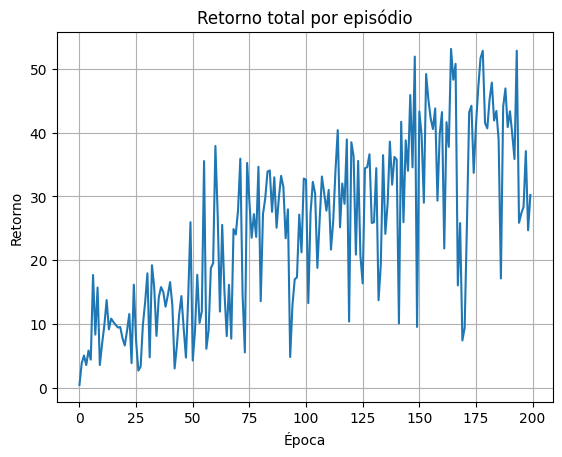

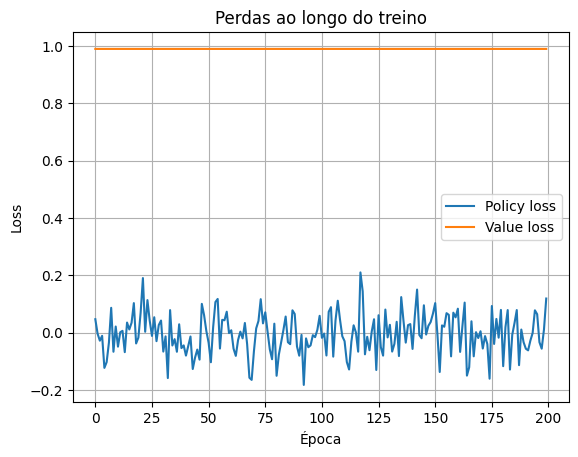

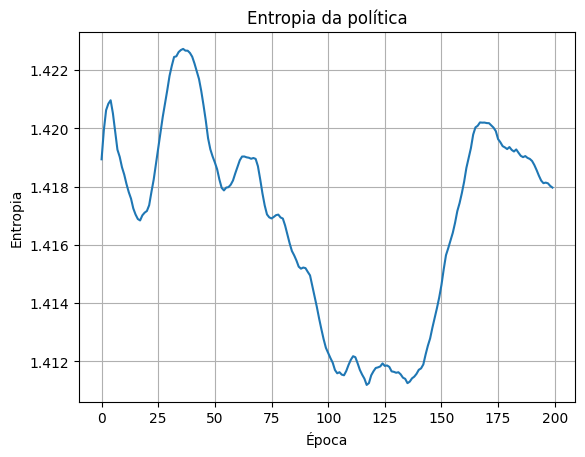

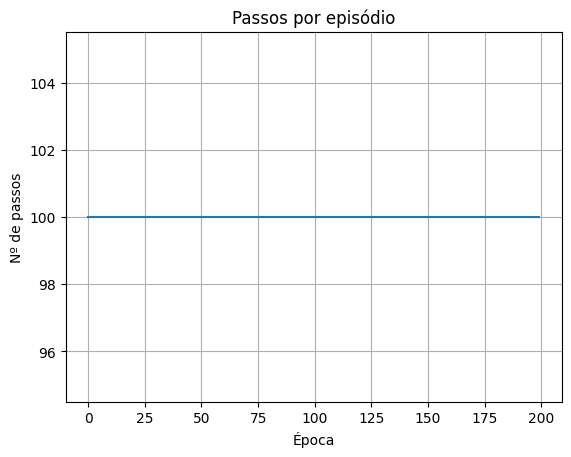

In [58]:
import matplotlib.pyplot as plt

# ---------- 1. Retorno ----------
plt.figure()
plt.plot(return_hist)
plt.title("Retorno total por episódio")
plt.xlabel("Época")
plt.ylabel("Retorno")
plt.grid(True)
plt.show()

# ---------- 2. Perdas ----------
plt.figure()
plt.plot(policy_loss_hist, label='Policy loss')
plt.plot(value_loss_hist,  label='Value loss')
plt.title("Perdas ao longo do treino")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ---------- 3. Entropia ----------
plt.figure()
plt.plot(entropy_hist)
plt.title("Entropia da política")
plt.xlabel("Época")
plt.ylabel("Entropia")
plt.grid(True)
plt.show()

# ---------- 4. Duração do episódio ----------
plt.figure()
plt.plot(ep_len_hist)
plt.title("Passos por episódio")
plt.xlabel("Época")
plt.ylabel("Nº de passos")
plt.grid(True)
plt.show()

In [61]:
# Rendering the trained agent
env_render = gym.make("racetrack-v0", render_mode="human")
env_render.unwrapped.configure(config)

obs, _ = env_render.reset()
obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
done = False
step = 0

while not done and step < 300:
    dist = actor(obs)
    action = dist.mean  
    obs_next, reward, done, truncated, _ = env_render.step(action.detach().cpu().numpy()[0])
    obs = torch.tensor(obs_next, dtype=torch.float32, device=device).unsqueeze(0)
    step += 1

env_render.close()